In [1]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torchvision
import torchvision.transforms as transforms

In [3]:
import os
os.environ['TORCH_HOME'] = './torch_home'

# for path for pretrained paths

### Not doing any training here. Using pretrained models for occlusion analysis and filter visualization. Can do  in cpu itself.

# Custom Dataset

- torchvision.datasets with custom folder of images we have. Can make a dataset from folder of images. Once we have dataset - can get dataloader, etc.

in colab. upload to files as a zip, and unzip that.  
(else will have to upload each file individually)  
!unzip data.zip to unzip.  

data folder with image folders and image labels.

**data** :
- folders(can have any name) with images. **Each folder - a class (order of the folder)**. The filenames doesn't matter - class label is assigned based on folder. (integer label)
- labels.txt (not used for making dataset - but can be read later for class names)

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

# those normalization numbers - mean, SD of 3 channels of the entire imagenet dataset.

In [5]:
# make a torch vision dataset(custom).
# 'ImageFolder' 

custom_dataset = torchvision.datasets.ImageFolder(root='./data/image_data', 
                                                  transform=transform)
# path, transform.

In [6]:
batch_size=4

# dataloader - (from the dataset)
dataloader = torch.utils.data.DataLoader(custom_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True)

In [7]:
# iterator - to get batches out of it.
dataiter = iter(dataloader)
images, labels = next(dataiter)

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
0


In [8]:
labels

# the labels are still 0,1,2 - Not the number assigned to the folders.
# So folders can also have any name.

tensor([0, 1, 2, 2])

In [9]:
# read the label file
with open("data/imagenet_labels.txt") as f:
    classes = eval(f.read())

# eval("expression") - runs the expression
    
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

This is the actual imagenet label file of 1000 classes.    
The folders are given same name as corresponding index of those classes. But that doesn't matter.  
Labels are still-0,1,2 -> it only looks at the order of folders to make the dataset.  

## Model (pretrained)

In [10]:
vgg = torchvision.models.vgg16(weights='DEFAULT')

# pretrined on the imagenet dataset

# data we have for testing is also from imagenet.
# so we don't want to do any more partial training.

In [11]:
vgg.eval() # set model in the eval mode.
# as we are going to do only inference

# things like dropout which are only used in training, .. are turned off.

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Utils

### show image

In [12]:
# function to display an image_grid
# after doing std, mean correction and transposing
def show_image(img, batch_size, title):
    
    # inverse correction for normalisation
    std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction #np.multiply - braodcast
    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    npimg = np.transpose(npimg, (1, 2, 0)) # transposing for matplotlib
    plt.imshow( (npimg*255).astype(np.uint8) )
    # casting to uint8 to avoid clipping warning
    plt.title(title)
    plt.show()

In [13]:
# function to show the next batch using dataloader
# along with predictions as title

def show_image_batch(dataloader, model):
    image_batch, _ = next(iter(dataloader))
    
    batch_size = len(image_batch) # getting batch_size from the loaded batch
    
    output_batch = model(image_batch) #prediction
    _, preds = torch.max(output_batch.data, 1)
        
    img = torchvision.utils.make_grid(image_batch) # make grid
    show_image(img, batch_size, title=[classes[x.item()] for x in preds])
    # a list is pased as title. The list gets printed
    
    # prediction is printed. Not the true label.
    # True label indexes are different here.
    
    return image_batch, preds #also return input, output

### Inference

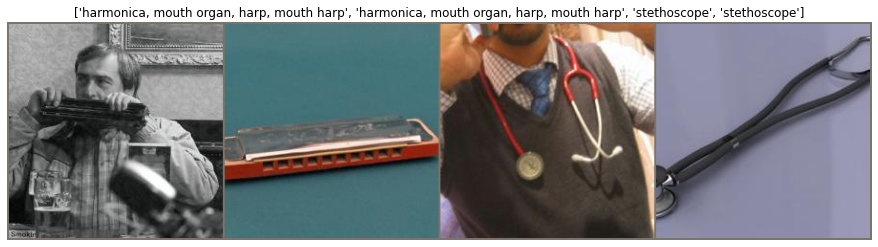

In [14]:
images, pred = show_image_batch(dataloader, vgg)